In [1]:
import os
import config as cfg
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog, canny
from skimage.morphology import remove_small_objects, closing
from skimage.color import rgb2gray
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from scipy.spatial import cKDTree
import json
import re
from scipy.spatial import Delaunay
from skimage.draw import polygon


plt.style.use('dark_background')

# Part 1 and 2

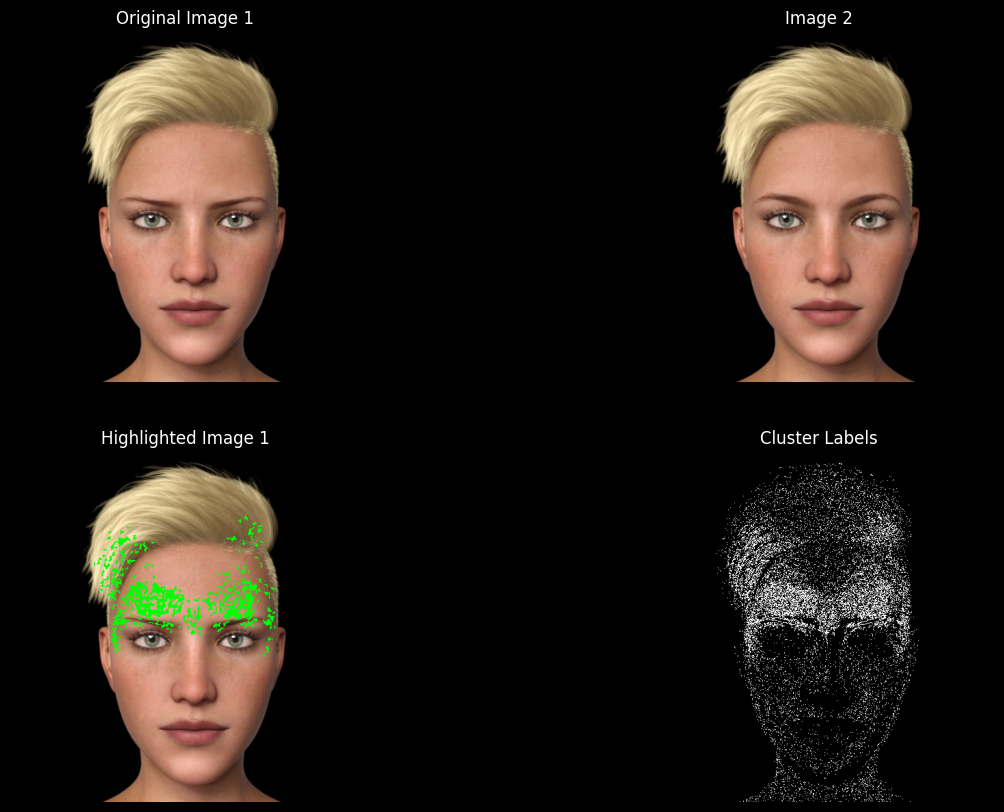

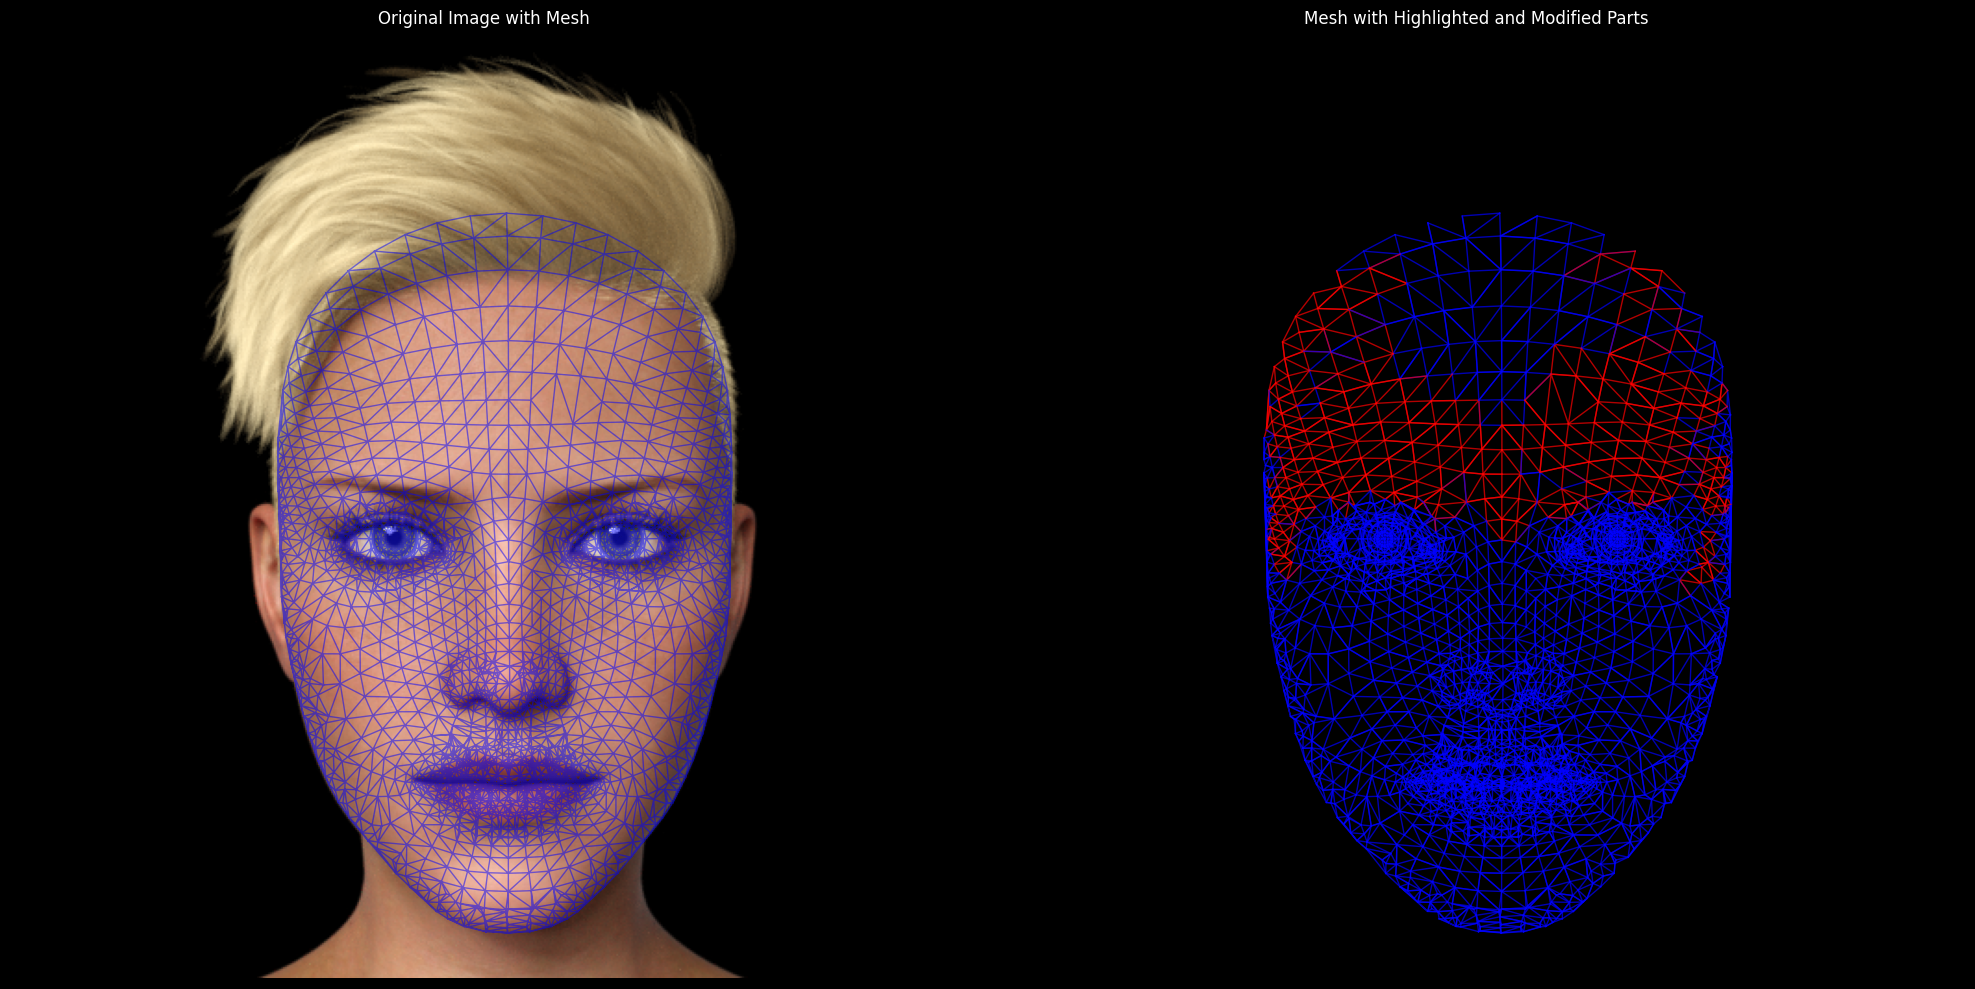

Shapes (512, 512) (512, 512)


In [33]:
def parse_vertex_file(file_path):
    batches = {}
    current_batch_key = None
    current_vertices = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            if '"batch":' in line:
                batch_match = re.search(r'\["([^"]+)","([^"]+)","([^"]+)"\]', line)
                if batch_match:
                    if current_batch_key and current_vertices:
                        batches[current_batch_key] = current_vertices
                    
                    batch = batch_match.group(1).split('=')[1]
                    camera = batch_match.group(2).split('=')[1]
                    image = batch_match.group(3).split('=')[1]
                    current_batch_key = (batch, camera, image)
                    current_vertices = []
            
            elif '"indexes":' in line:
                while True:
                    vertex_line = next(file, None)
                    if vertex_line is None or '}' in vertex_line:
                        break
                    vertex_match = re.search(r'"(\d+;\d+)":\[([^]]+)\]', vertex_line)
                    if vertex_match:
                        index = vertex_match.group(1)
                        coords = [float(x) for x in vertex_match.group(2).split(',')]
                        current_vertices.append((index, coords))
    
    if current_batch_key and current_vertices:
        batches[current_batch_key] = current_vertices

    return batches


def find_specific_vertices(file_path, target_batch, target_camera, target_image):
    batches = parse_vertex_file(file_path)
    
    target_key = (str(target_batch), target_camera, str(target_image))
    
    if target_key in batches:
        return batches[target_key]
    else:
        return None

class ImageProcessingPipeline:
    """
    A class to process images and detect changes between them.
    The class reads the images from either batch 1 or batch 2.
    Compares the image 0 with the image specified by the comparison_id.
    The class also reads the vertex data from the vertex file and highlights the changes on the mesh,
    from comparison between image 0 and the specified image.
    """
    def __init__(self: object, 
                 cfg: object) -> None:
        self.cfg = cfg

    def remove_outliers(self: object, 
                        data: np.ndarray, 
                        factor: float=1.5) -> np.ndarray:
        """
        Data had some big outliers in terms of their placement on the mesh.
        They did not seem that important, so I removed them
        """
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return np.where((data >= lower_bound) & (data <= upper_bound))

    def compute_lbp(self: object, 
                    image: np.ndarray, 
                    radius: int=1, 
                    n_points: int=8) -> np.ndarray:
        """
        MAin method used to compute the Local Binary Pattern of an image. 
        Will use the results of this function with HOG to detect changes in the images.
        """
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        return lbp

    def compute_canny(self: object, 
                      image: np.ndarray, 
                      sigma: float=1.0) -> np.ndarray:
        """
        Experimental addition to the pipeline.
        Main idea of adding Canny was to see if it can help with lowering the number of false positives.
        """
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = canny(gray_image, sigma=sigma)
        return edges

    def compute_hog(self: object, 
                    image: np.ndarray) -> np.ndarray:
        """
        Main method used to compute the Histogram of Oriented Gradients of an image.
        Used in conjunction with LBP to detect changes in the images.
        """
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True)
        return hog_image

    def combine_features(self: object, 
                         lbp: np.ndarray, 
                         hog: np.ndarray) -> np.ndarray:
        """
        Combines the LBP and HOG features into a single array.
        For further processing and clustering.
        """
        lbp_flatten = lbp.ravel()
        hog_flatten = hog.ravel()
        combined = np.vstack((lbp_flatten, hog_flatten)).T
        return combined

    def find_changes(self: object, 
                     image1: np.ndarray, 
                     image2: np.ndarray, 
                     radius: int=1, 
                     n_points: int=8, 
                     k: int=2) -> tuple:
        """
        Main function that detects changes between two images.
        The function uses LBP and HOG features to detect changes.
        The changes are then clustered using KMeans.
        The cluster with the smallest size is considered to be the change cluster.
        Chose to use KMeans because it is simple and fast and solves the problem with thresholding.
        
        Comments:
        - The function could be improved by using a more sophisticated clustering algorithm.
        - The function could be improved by using a different distance metric for clustering (tried cosine distance, but it did not work well)
        - The function could be improved by using a different feature combination.
        - The function could be improved by performing some preprocessing on the images before feature extraction.
            - Tried to remove some noise from the data using Guassian filter, but results were not good.
        """
        lbp1 = self.compute_lbp(image1, radius, n_points)
        lbp2 = self.compute_lbp(image2, radius, n_points)
        
        hog1 = self.compute_hog(image1)
        hog2 = self.compute_hog(image2)
        
        combined1 = self.combine_features(lbp1, hog1)
        combined2 = self.combine_features(lbp2, hog2)
        diff = np.abs(combined1 - combined2)
        
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(diff)
        labels = labels.reshape(image1.shape[:2])
            
        cluster_sizes = [np.sum(labels == i) for i in range(k)]
        change_cluster = np.argmin(cluster_sizes)
        change_cluster = labels == change_cluster
        
        change_mask = remove_small_objects(change_cluster, min_size=9)
        change_mask = closing(change_mask)
        change_mask = clear_border(change_mask)
        
        highlighted_image = image1.copy()
        highlighted_image[change_mask] = [0, 255, 0]
        
        return highlighted_image, diff, labels, change_mask

    def visualize_images(self: object, 
                         image1: np.ndarray, 
                         image2: np.ndarray, 
                         highlighted_image: np.ndarray, 
                         labels: np.ndarray) -> None:
        """
        Visualizes the images, highlighted image changes and the cluster labels.
        """
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.title("Original Image 1")
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(2, 2, 2)
        plt.title("Image 2")
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(2, 2, 3)
        plt.title("Highlighted Image 1")
        plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(2, 2, 4)
        plt.title("Cluster Labels")
        plt.imshow(labels, cmap='gray')
        plt.axis('off')
        
        plt.show()

    def highlight_mesh_changes(self: object, 
                               change_mask: np.ndarray, 
                               image1: np.ndarray, 
                               x_coords: np.ndarray, 
                               y_coords: np.ndarray) -> None:
        """
        Highlights the changes on the mesh.
        """
        w,  h = image1.shape[:2]
        points = np.column_stack((x_coords, y_coords))
        tri = Delaunay(points)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        ax1.triplot(x_coords, y_coords, tri.simplices, 'b-', lw=1, alpha=0.5)
        ax1.set_title("Original Image with Mesh")
            
        changed_triangles = []
        unchanged_triangles = []
        for simplex in tri.simplices:
            triangle_x = x_coords[simplex]
            triangle_y = y_coords[simplex]
            
            rr, cc = polygon(triangle_y, triangle_x, change_mask.shape)
            triangle_mask = np.zeros_like(change_mask, dtype=bool)
            triangle_mask[rr, cc] = True
            
            if np.any(change_mask[triangle_mask]):
                changed_triangles.append(simplex)
                color = 'r'
            else:
                unchanged_triangles.append(simplex)
                color = 'b'
            
            ax2.plot(triangle_x, triangle_y, color+'-', lw=1, alpha=0.7)
        
        ax2.set_title("Mesh with Highlighted and Modified Parts")
        
        for ax in (ax1, ax2):
            ax.set_xlim(0, w)
            ax.set_ylim(h, 0)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    def transfer_changes_to_vertices(self: object, 
                                     change_mask: np.ndarray, 
                                     vertex_data: np.ndarray) -> tuple:
        """
        Function that transfers the changes from the image to the vertices.
        The function uses the KDTree to find the closest vertex to the changed pixel.
        The function then returns a mask of the vertices that were changed.
        """
        vertices = self.parse_vertex_data(vertex_data)
        changed_pixels = np.column_stack(np.where(change_mask))
        tree = cKDTree(vertices)
        distances, indices = tree.query(changed_pixels)
        vertex_change_mask = np.zeros(vertices.shape[0], dtype=bool)
        vertex_change_mask[indices] = True
        return vertex_change_mask, vertices

    def process_images(self: object, 
                       bath_index: int=1, 
                       render_type: str='Front', 
                       comparison_id: int = 1)  -> tuple:
        """
        Main function that processes the images and finds the changes on the mesh.
        bath_index: int - index of the batch (1 or 2)
        render_type: str - type of the render (Front, Side, Top)
        comparison_id: int - id of the image to compare to (0~49)
        """
        
        assert bath_index in [1, 2], "Batch index must be 1 or 2"
        assert render_type in self.cfg.RENDER_TYPES, f"Position must be one of {self.cfg.RENDER_TYPES}"
        
        image1 = cv2.imread(os.path.join(self.cfg.BATCH_RENDER_DIR[bath_index - 1], f'Render_0_{render_type}.png'))
        image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        
        w, h = image1_gray.shape
        
        image2 = cv2.imread(os.path.join(self.cfg.BATCH_RENDER_DIR[bath_index - 1], f'Render_{comparison_id}_{render_type}.png'))
        image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
        
        file_path = os.path.join(self.cfg.BATCH_DIR[bath_index - 1], 'vertex_3k.txt')
        target_camera = f'Camera_{render_type}'
        
        vertices = find_specific_vertices(file_path, bath_index - 1, target_camera, 0)
        
        coords = np.array([x[1] for x in vertices])
        
        x_coords = coords[:, 0]
        y_coords = coords[:, 1]
        valid_indices = np.intersect1d(self.remove_outliers(x_coords), self.remove_outliers(y_coords))
        x_coords_clean = x_coords[valid_indices]
        y_coords_clean = y_coords[valid_indices]
        
        highlighted_image, diff, labels, change_mask = self.find_changes(image1, image2)
        
        self.visualize_images(image1, image2, highlighted_image, labels)
        self.highlight_mesh_changes(change_mask, image1, x_coords_clean, h - y_coords_clean)
        
        print('Shapes', image1_gray.shape, image2_gray.shape)

        return highlighted_image, change_mask, x_coords_clean, y_coords_clean

pipeline = ImageProcessingPipeline(cfg)
highlighted_image, change_mask, x_coords_clean, y_coords_clean = pipeline.process_images(bath_index=2, render_type='Front', comparison_id=30)


The method used strugles with very small changes in parameters, but it is able to detect some of  the regions even in those circumstances.
The method performs best on bigger changes, but this could be expected.

# Part 3

In [34]:
import pandas as pd

def remove_outliers(data, factor=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return np.where((data >= lower_bound) & (data <= upper_bound))

(256, 256, 3)


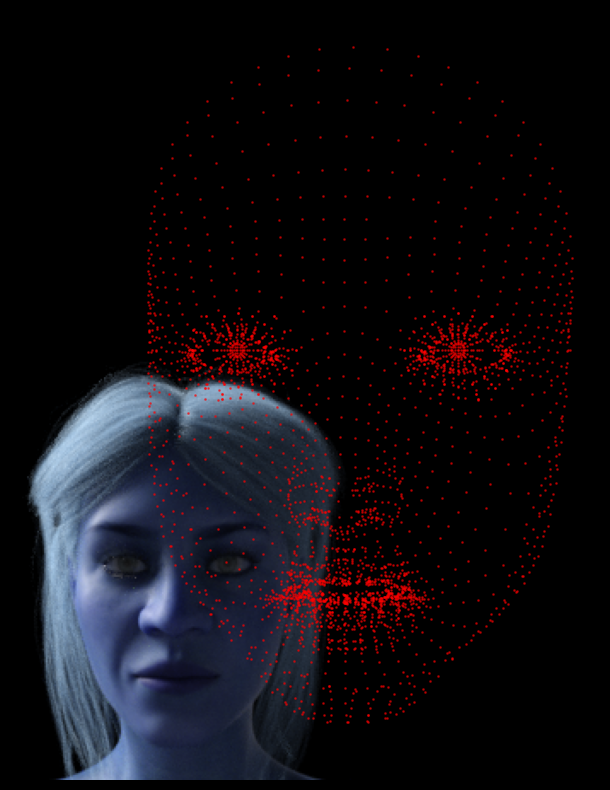

In [35]:
data = pd.read_csv(os.path.join(cfg.ANNOTATIONS_DIR, 'train_set-1-full.csv'))

image = cv2.imread(os.path.join(cfg.TRAIN_BATCH_RENDER_DIR, 'Render_0_Front.png'))
image_width, image_height, _ = image.shape
print(image.shape)

data_filtered = data[(data['id'] == 0) & (data['camera_type'] == 'Front')]

x_coords = data_filtered.filter(regex='_x$').values.flatten()
y_coords = data_filtered.filter(regex='_y$').values.flatten()

valid_indices = np.intersect1d(remove_outliers(x_coords), remove_outliers(y_coords))
x_coords_clean = x_coords[valid_indices]
y_coords_clean = y_coords[valid_indices]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap='gray')
ax.scatter(x_coords_clean, 256 - y_coords_clean, c='r', s=1, alpha=0.5)
ax.axis('off')
plt.show()

Due  to the  fact that position  of the  head changes in the data, it is hard to detect the changes in the mesh, without reverting the transformations.
Sadly did not find a proper way  to find the initial coordinates before or after the transformation.
Trie to check will the transformation will be applied to the mesh and thus we could reverse engineer the transformation on the initial image.


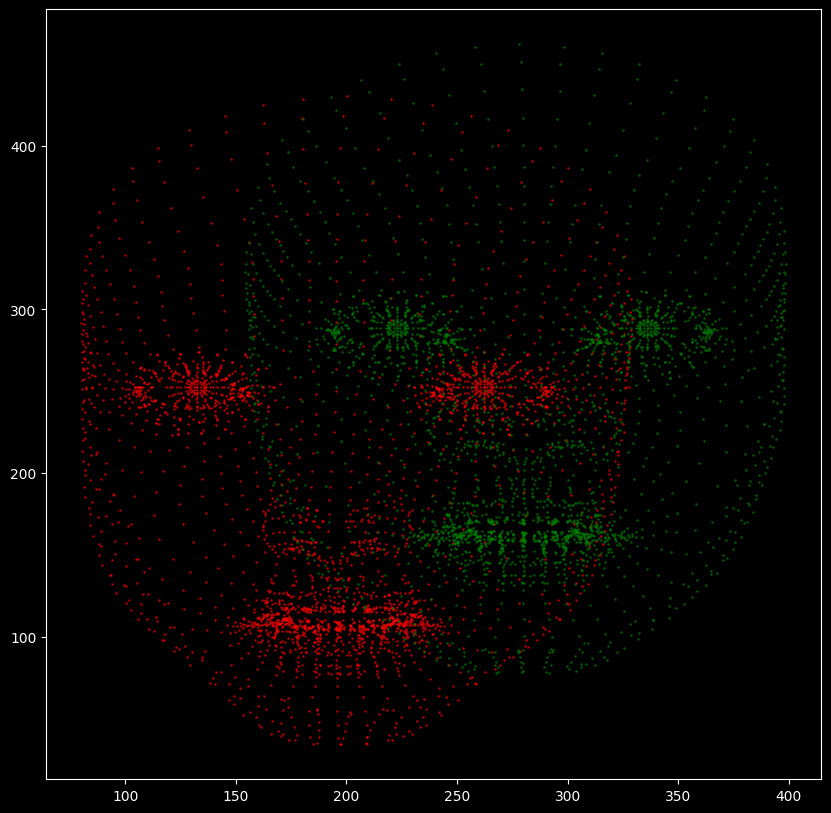

In [36]:
data_filtered_a = data[(data['id'] == 0) & (data['camera_type'] == 'Front')]

x_coords_a = data_filtered_a.filter(regex='_x$').values.flatten()
y_coords_a = data_filtered_a.filter(regex='_y$').values.flatten()

valid_indices = np.intersect1d(remove_outliers(x_coords_a), remove_outliers(y_coords_a))
x_coords_a = x_coords_a[valid_indices]
y_coords_a = y_coords_a[valid_indices]


data_filtered_b = data[(data['id'] == 1) & (data['camera_type'] == 'Front')]

x_coords_b = data_filtered_b.filter(regex='_x$').values.flatten()
y_coords_b = data_filtered_b.filter(regex='_y$').values.flatten()

valid_indices = np.intersect1d(remove_outliers(x_coords_b), remove_outliers(y_coords_b))
x_coords_b = x_coords_b[valid_indices]
y_coords_b = y_coords_b[valid_indices]

coords_a = np.column_stack((x_coords_a, y_coords_a))
coords_b = np.column_stack((x_coords_b, y_coords_b))

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_coords_a, y_coords_a, c='r', s=1, alpha=0.5)
ax.scatter(x_coords_b, y_coords_b, c='g', s=1, alpha=0.5)
# ax.axis('off')
plt.show()

In [37]:
def best_fit_transform(A, B):
    """
    Calculates the least-squares best-fit transform between corresponding 2D points A->B
    """
    assert A.shape == B.shape

    # Get number of dimensions
    m = A.shape[1]

    # Translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # Rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # Translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # Homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

def nearest_neighbor(src, dst):
    """
    Find the nearest (Euclidean) neighbor in dst for each point in src
    """
    neigh = np.argmin(np.sum((src[:, np.newaxis] - dst)**2, axis=2), axis=1)
    return dst[neigh]

def icp(A, B, max_iterations=20, tolerance=0.001):
    """
    The Iterative Closest Point method
    """
    src = np.array(A.copy())
    dst = np.array(B.copy())
    
    prev_error = 0

    for i in range(max_iterations):
        # Find the nearest neighbors between the current source and destination points
        src_matched = nearest_neighbor(src, dst)

        # Estimate transformation
        T, R, t = best_fit_transform(src, src_matched)

        # Transform the source points
        src = np.dot(src, R.T) + t

        # Calculate the mean error
        mean_error = np.mean(np.sum((src - src_matched)**2, axis=1))
        
        # Check for convergence
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # Calculate final transformation
    T, R, t = best_fit_transform(A, src)

    return T, R, t
# Trying to approximate the matrix of transformation between the meshes

T, R, t = icp(coords_a, coords_b)

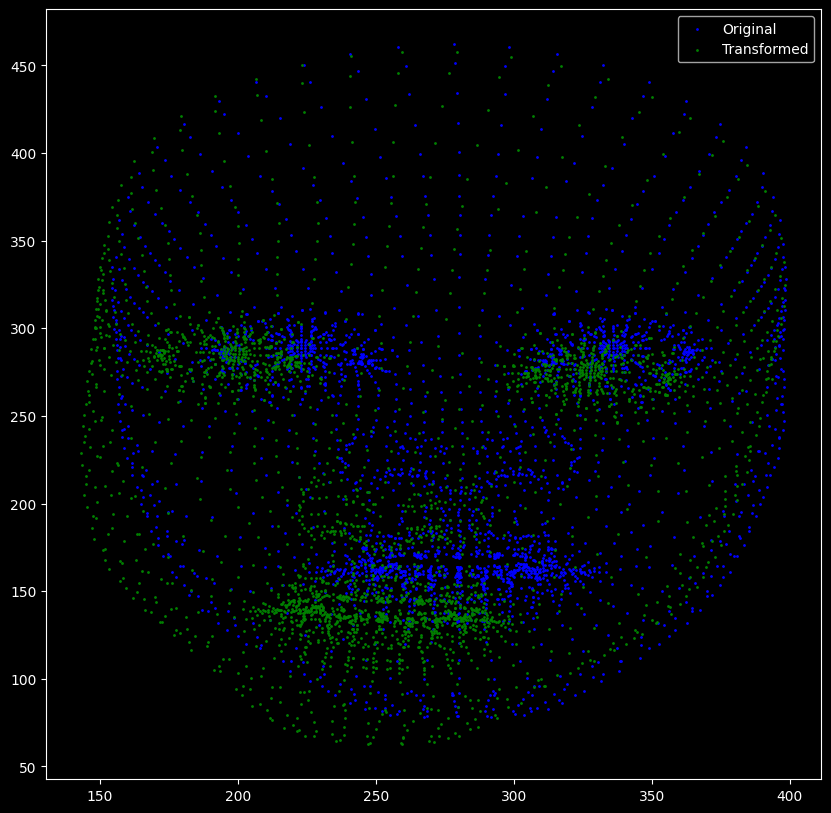

In [39]:
def apply_transformation(coords, T):
    return np.dot(np.c_[coords, np.ones(coords.shape[0])], T.T)[:, :2]

reconstructed_coords = apply_transformation(coords_a, T)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(coords_b[:, 0], coords_b[:, 1], c='blue', label='Original', s=1)
ax.scatter(reconstructed_coords[:, 0], reconstructed_coords[:, 1], c='green', label='Transformed', s=1)
ax.legend()
# ax.axis('off')
plt.show()

Trying to apply the same transformation on the images, maybe the same transformation was used.

In [40]:
def transform_image(image, T):
    """
    Transform an image based on the transformation matrix T.
    """
    height, width = image.shape[:2]    
    rotation = T[:2, :2]
    translation = T[:2, 2]
    
    scale = np.sqrt(rotation[0, 0]**2 + rotation[0, 1]**2)    
    full_transform = np.concatenate([rotation * scale, translation.reshape(2, 1)], axis=1)
    
    transformed_image = cv2.warpAffine(image, full_transform, (width, height), 
                                       flags=cv2.INTER_LINEAR, 
                                       borderMode=cv2.BORDER_CONSTANT, 
                                       borderValue=0)
    return transformed_image

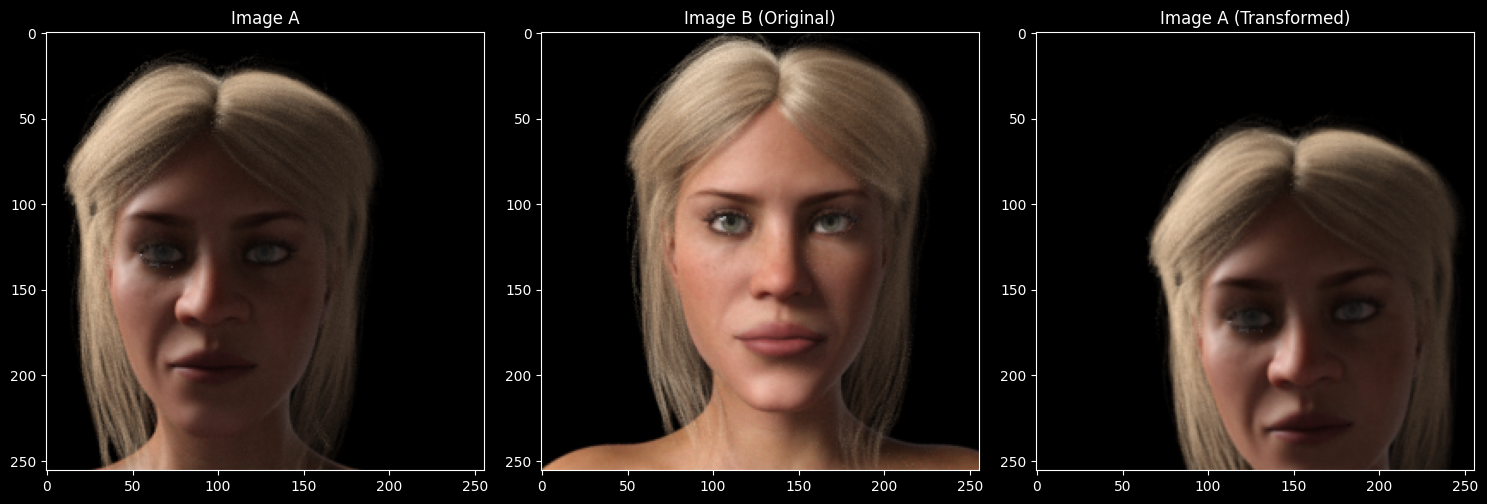

In [41]:
image1 = cv2.imread(os.path.join(cfg.TRAIN_BATCH_RENDER_DIR, 'Render_0_Front.png'))
image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

image2 = cv2.imread(os.path.join(cfg.TRAIN_BATCH_RENDER_DIR, 'Render_1_Front.png'))
image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

transformed_image = transform_image(image1, T)

plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
plt.title("Image A")
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    
plt.subplot(1, 3, 2)
plt.title("Image B (Original)")
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    
plt.subplot(1, 3, 3)
plt.title("Image A (Transformed)")
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    
plt.tight_layout()
plt.show()

As you can see, the transformation did not work. The images are not aligned properly.
Sadly, could not manage to solve this problem.

# Part 4

# Data preparation

The data is prepared in the following way:
- Would add additional features, like shadows, noise, etc. to the dataa
- Divide the data into train and validation and test sets.

Model architecture:
- The initial model should be simple for testing purposes and with a well  known architecture.
    - Easiest architecture would probabl be U-Net.
    - Another probable architecture would be a Mask R-CNN.
- Would add early stopping to the model, seems the model could overfit the data quickly.
- Input  should the facial images.
- Output should segmentation masks for face parts.

Loss function:
- The loss function should be a combination of different loss functions.
    - Jaccard loss
    - L2 loss for mesh coordinate prediction
    - Custom loss, to enforce some specific constraints on the model.
        -  Do not  have  any ideas for this loss function yet.
 

In [ ]:
# DAta 